In [1]:
from unet import multi_unet_model #Uses softmax 

import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from natsort import natsorted


#Resizing images, if needed
SIZE_X = 128 
SIZE_Y = 128
n_classes=9 #Number of classes for segmentation
myimages = glob.glob(os.path.join("Images/*.*"))
myimages = natsorted(myimages)
#Capture training image info as a list
train_images = []

#for directory_path in glob.glob("Images/"):
for img_path in myimages:
        #print(img_path)
        img = cv2.imread(img_path, 0)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)
       
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

#Capture mask/label info as a list
mymasks = glob.glob(os.path.join("Labels/*.*"))
mymasks = natsorted(mymasks)
train_masks = [] 
for mask_path in mymasks:
        #print(mask_path)
        mask = cv2.imread(mask_path, 0)   
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
          #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(np.unique(train_masks))

2021-09-04 00:27:28.187656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/geojob/snake_ws/devel/lib:/opt/ros/noetic/lib
2021-09-04 00:27:28.187676: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[0 1 2 3 4 5 6 7 8]


In [2]:
print(np.unique(train_masks[7]))

[0 1 2 3 4 5 6 7 8]


In [3]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)
train_images = np.expand_dims(train_images, axis=3)
train_images = tf.keras.utils.normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

/home/geojob/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.17, random_state = 0)

In [8]:
train_masks_cat = tf.keras.utils.to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
test_masks_cat = tf.keras.utils.to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [9]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
class_weights = {i : class_weights[i] for i in range(9)}
print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()

/home/geojob/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
2021-09-03 21:35:53.118922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../../../lib:/home/geojob/snake_ws/devel/lib:/opt/ros/noetic/lib
2021-09-03 21:35:53.118961: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-03 21:35:53.118976: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (batComp): /proc/driver/nvidia/version does not exis

Class weights are...: {0: 0.12953815938087654, 1: 5.637534473296206, 2: 5.549543324475877, 3: 5.616055666958027, 4: 5.591560783992519, 5: 5.596287813967151, 6: 5.582387404193264, 7: 9.545866361366741, 8: 9.68939985333428}


In [10]:
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = tf.keras.backend.argmax(true, axis=axis) 
       
        
            #if your loss is sparse, use only true as classSelectors
        classSelectors = tf.cast(classSelectors,tf.int32)
       
       
        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [tf.keras.backend.equal(i, classSelectors) for i in range(len(weightsList))]
        
        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [tf.keras.backend.cast(x, tf.keras.backend.floatx()) for x in classSelectors]


        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 
        
        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]

        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier
        return loss
    return lossFunc

In [11]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size = 2, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        dropout_2[0][0]                  
____________________________________________________________________________________________

2021-09-03 21:35:53.713495: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
83/83 [==============================] - 11s 125ms/step - loss: 0.9425 - accuracy: 0.7519 - val_loss: 0.6155 - val_accuracy: 0.8581
Epoch 2/100
83/83 [==============================] - 10s 125ms/step - loss: 0.4346 - accuracy: 0.8623 - val_loss: 0.4729 - val_accuracy: 0.8633
Epoch 3/100
83/83 [==============================] - 11s 134ms/step - loss: 0.3950 - accuracy: 0.8676 - val_loss: 0.3870 - val_accuracy: 0.8675
Epoch 4/100
83/83 [==============================] - 11s 134ms/step - loss: 0.3587 - accuracy: 0.8699 - val_loss: 0.3433 - val_accuracy: 0.8744
Epoch 5/100
83/83 [==============================] - 11s 133ms/step - loss: 0.3198 - accuracy: 0.8775 - val_loss: 0.3163 - val_accuracy: 0.8793
Epoch 6/100
83/83 [==============================] - 11s 134ms/step - loss: 0.2952 - accuracy: 0.8828 - val_loss: 0.2897 - val_accuracy: 0.8853
Epoch 7/100
83/83 [==============================] - 11s 135ms/step - loss: 0.2738 - accuracy: 0.8918 - val_loss: 0.2593 - val_accuracy:

In [13]:

_, acc= model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


2/2 [==============================] - 1s 31ms/step - loss: 0.2253 - accuracy: 0.9360
Accuracy is =  93.60010623931885 %


In [14]:
model.save('Recycle.hdf5')

In [5]:
import keras
model = keras.models.load_model('Recycle.hdf5')


2021-09-04 00:28:32.099027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../../../lib:/home/geojob/snake_ws/devel/lib:/opt/ros/noetic/lib
2021-09-04 00:28:32.099048: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-04 00:28:32.099063: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (batComp): /proc/driver/nvidia/version does not exist
2021-09-04 00:28:32.099193: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

In [6]:

y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
from keras.metrics import MeanIoU
n_classes = 9
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

2021-09-04 00:28:35.167818: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Mean IoU = 0.5022337


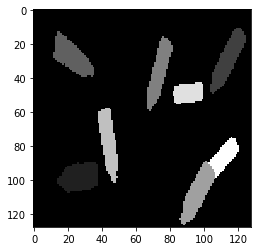

In [7]:
plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

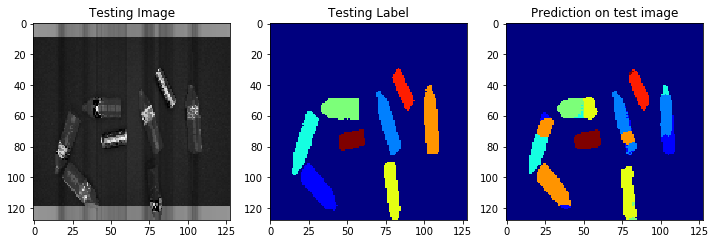

In [28]:
import random
test_img_number = random.randint(0, len(X_test))
#print(test_img_number)
test_img = X_test[test_img_number]
#print(test_img)
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
res = np.float32(test_img)
res = res*255;
res = cv2.resize(res, dsize=(1920, 1080), interpolation=cv2.INTER_CUBIC)

res2 = np.float32(predicted_img)
res2 = cv2.resize(res2, dsize=(1920, 1080), interpolation=cv2.INTER_CUBIC)
cv2.imwrite('test.jpg', res)
cv2.imwrite('result.jpg',res2)


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.image as mpimg
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import random
from PIL import Image
import cv2
%matplotlib inline
import os
import skimage.draw
#from visualize import display_instances
from skimage.color import gray2rgb
from math import atan2, cos, sin, sqrt, pi, ceil

In [30]:
def getOrientation(pts, img, label):
  ## [pca]
  # Construct a buffer used by the pca analysis
  sz = len(pts)
  data_pts = np.empty((sz, 2), dtype=np.float64)
  for i in range(data_pts.shape[0]):
    print(pts[i])
    data_pts[i,0] = pts[i,0,0]
    data_pts[i,1] = pts[i,0,1]
  print(data_pts)
 
  # Perform PCA analysis
  mean = np.empty((0))
  mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
  #print(eigenvectors)
  #print(eigenvalues)
 
  # Store the center of the object
  cntr = (int(mean[0,0]), int(mean[0,1]))
  ## [pca]
 
  ## [visualization]
  # Draw the principal components
  cv2.circle(img, cntr, 3, (255, 0, 255), 2)
  p1 = (cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0])
  p2 = (cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0])
  drawAxis(img, cntr, p1, (255, 255, 0), 1)
  drawAxis(img, cntr, p2, (0, 0, 255), 5)
 
  angle = atan2(eigenvectors[0,1], eigenvectors[0,0]) # orientation in radians

  if label ==1:
    name = "Cola bottle"
  if label ==2:
    name = "Fanta bottle"
  if label ==3:
    name = "Cherry cola bottle"
  if label ==4:
    name = "Zero cola bottle"
  if label ==5:
    name = "Mountain dew bottle"
  if label ==6:
    name = "Cola bottle"
  if label ==7:
    name = "Fanta can" 
  if label ==8:
    name = "Cola can" #"Zero Cola bottle"
  ## [visualization]
 
  # Label with the rotation angle
  label = "  Rotation Angle: " + str(-int(np.rad2deg(angle)) - 90) + " degrees" + " " + name
  textbox = cv2.rectangle(img, (cntr[0], cntr[1]-25), (cntr[0] + 400, cntr[1] + 10), (255,255,255), -1)
  cv2.putText(img, label, (cntr[0], cntr[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
 
  return angle

In [31]:
def drawAxis(img, p_, q_, color, scale):
  p = list(p_)
  q = list(q_)
 
  ## [visualization1]
  angle = atan2(p[1] - q[1], p[0] - q[0]) # angle in radians
  hypotenuse = sqrt((p[1] - q[1]) * (p[1] - q[1]) + (p[0] - q[0]) * (p[0] - q[0]))
 
  # Here we lengthen the arrow by a factor of scale
  q[0] = p[0] - scale * hypotenuse * cos(angle)
  q[1] = p[1] - scale * hypotenuse * sin(angle)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)
 
  # create the arrow hooks
  p[0] = q[0] + 9 * cos(angle + pi / 4)
  p[1] = q[1] + 9 * sin(angle + pi / 4)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)
 
  p[0] = q[0] + 9 * cos(angle - pi / 4)
  p[1] = q[1] + 9 * sin(angle - pi / 4)
  cv2.line(img, (int(p[0]), int(p[1])), (int(q[0]), int(q[1])), color, 3, cv2.LINE_AA)

In [32]:
path = os.path.join(os.path.expanduser('~'), 'EvteK','test.jpg')
path2 = os.path.join(os.path.expanduser('~'), 'EvteK','result.jpg')
print(path)

/home/geojob/EvteK/test.jpg


In [33]:
# Load images as greyscale but make main RGB so we can annotate in colour
SIZE_X = 1080
SIZE_Y = 1920


seg  = cv2.imread(path2,cv2.IMREAD_GRAYSCALE)
main = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
main = cv2.cvtColor(main,cv2.COLOR_GRAY2BGR)
#cv2.imshow('image', main)
# Dictionary giving RGB colour for label (segment label) - label 1 in red, label 2 in yellow
RGBforLabel = { 1:(230, 25, 75), 2:(60, 180, 75), 3:(255, 225, 25), 4:(0, 130, 200), 5:(245, 130, 48), 6:(145, 30, 180), 7:(0, 200, 240), 8:(128, 128, 0) }

# Find external contours
contours,_ = cv2.findContours(seg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
#print(contours)

# Iterate over all contours
for i,c in enumerate(contours):
    # Find mean colour inside this contour by doing a masked mean
    #print(i)
    area = cv2.contourArea(c)
    mask = np.zeros(seg.shape, np.uint8)
    cv2.drawContours(mask,[c],-1,255, -1)
    #cv2.imwrite(f"mask-{i}.png",mask)
    mean,_,_,_ = cv2.mean(seg, mask=mask)
    # DEBUG: print(f"i: {i}, mean: {mean}")
    #print(mean)
    # Get appropriate colour for this label
    label = ceil(mean)
    #print(label)
    #label=8
    colour = RGBforLabel.get(label)
    x,y,w,h = cv2.boundingRect(c)
    img = cv2.rectangle(main,(x,y),(x+w,y+h),colour,2)
    if len(c) >1:
      getOrientation(c,main,label)
    #cv2.drawContours(main,[c],-1,colour,1)
    

# Save result
cv2.imshow('result', main)
cv2.waitKey(0)

[[1176  781]]
[[1175  782]]
[[1174  782]]
[[1173  782]]
[[1172  782]]
[[1171  782]]
[[1170  783]]
[[1169  783]]
[[1168  784]]
[[1168  785]]
[[1168  786]]
[[1167  787]]
[[1166  787]]
[[1165  788]]
[[1164  789]]
[[1163  790]]
[[1162  790]]
[[1161  790]]
[[1160  790]]
[[1160  791]]
[[1159  792]]
[[1158  792]]
[[1157  792]]
[[1156  792]]
[[1155  792]]
[[1154  793]]
[[1153  794]]
[[1152  794]]
[[1152  795]]
[[1151  796]]
[[1150  797]]
[[1149  797]]
[[1148  798]]
[[1147  799]]
[[1146  799]]
[[1145  799]]
[[1144  799]]
[[1143  799]]
[[1142  799]]
[[1141  799]]
[[1140  799]]
[[1139  799]]
[[1138  799]]
[[1137  799]]
[[1136  799]]
[[1135  798]]
[[1134  798]]
[[1133  798]]
[[1132  798]]
[[1131  798]]
[[1130  798]]
[[1129  798]]
[[1128  798]]
[[1127  799]]
[[1126  799]]
[[1125  799]]
[[1124  799]]
[[1123  800]]
[[1122  800]]
[[1121  800]]
[[1120  800]]
[[1120  801]]
[[1120  802]]
[[1120  803]]
[[1120  804]]
[[1119  805]]
[[1119  806]]
[[1118  807]]
[[1119  808]]
[[1119  809]]
[[1119  810]]
[[1119

[[309 560]]
[[309 561]]
[[309 562]]
[[309 563]]
[[309 564]]
[[309 565]]
[[309 566]]
[[309 567]]
[[309 568]]
[[309 569]]
[[309 570]]
[[310 571]]
[[310 572]]
[[310 573]]
[[311 574]]
[[311 575]]
[[310 576]]
[[310 577]]
[[309 578]]
[[308 579]]
[[307 579]]
[[306 580]]
[[305 580]]
[[304 580]]
[[303 580]]
[[302 580]]
[[301 581]]
[[300 581]]
[[299 581]]
[[298 581]]
[[297 582]]
[[296 582]]
[[296 583]]
[[295 584]]
[[294 584]]
[[294 585]]
[[294 586]]
[[294 587]]
[[294 588]]
[[294 589]]
[[294 590]]
[[294 591]]
[[294 592]]
[[294 593]]
[[294 594]]
[[294 595]]
[[294 596]]
[[294 597]]
[[294 598]]
[[294 599]]
[[295 600]]
[[294 601]]
[[294 602]]
[[294 603]]
[[294 604]]
[[293 605]]
[[292 606]]
[[291 606]]
[[290 606]]
[[289 607]]
[[288 607]]
[[287 607]]
[[286 607]]
[[285 607]]
[[284 607]]
[[283 608]]
[[282 609]]
[[281 610]]
[[280 610]]
[[280 611]]
[[280 612]]
[[280 613]]
[[280 614]]
[[280 615]]
[[280 616]]
[[280 617]]
[[280 618]]
[[280 619]]
[[281 620]]
[[281 621]]
[[281 622]]
[[281 623]]
[[282 624]]
[[28

[[379 490]]
[[378 490]]
[[377 490]]
[[376 490]]
[[375 489]]
[[374 489]]
[[373 489]]
[[372 489]]
[[371 489]]
[[370 489]]
[[369 489]]
[[368 489]]
[[367 489]]
[[366. 489.]
 [365. 490.]
 [364. 490.]
 ...
 [369. 489.]
 [368. 489.]
 [367. 489.]]
[[782 402]]
[[781 403]]
[[780 403]]
[[779 404]]
[[778 405]]
[[777 406]]
[[777 407]]
[[776 408]]
[[775 408]]
[[776 409]]
[[775 410]]
[[774 410]]
[[773 410]]
[[772 411]]
[[771 411]]
[[770 411]]
[[769 411]]
[[768 411]]
[[767 411]]
[[766 411]]
[[765 411]]
[[764 411]]
[[763 411]]
[[762 411]]
[[761 411]]
[[760 411]]
[[759 410]]
[[758 410]]
[[757 410]]
[[756 410]]
[[755 410]]
[[754 410]]
[[753 410]]
[[752 410]]
[[751 410]]
[[750 410]]
[[749 410]]
[[748 410]]
[[747 410]]
[[746 410]]
[[745 410]]
[[744 410]]
[[743 410]]
[[742 410]]
[[741 410]]
[[740 410]]
[[739 410]]
[[738 410]]
[[737 410]]
[[736 410]]
[[735 410]]
[[734 410]]
[[733 410]]
[[732 410]]
[[731 410]]
[[730 410]]
[[729 410]]
[[728 410]]
[[727 410]]
[[726 410]]
[[725 410]]
[[724 410]]
[[723 410]]
[[72

[[1213  536]]
[[1213  535]]
[[1212  534]]
[[1211  534]]
[[1210  533]]
[[1209  533]]
[[1208  533]]
[[1207  532]]
[[1206  531]]
[[1205  531]]
[[1204  530]]
[[1204  529]]
[[1203  528]]
[[1202  527]]
[[1202  526]]
[[1202  525]]
[[1202  524]]
[[1201  523]]
[[1201  522]]
[[1200  521]]
[[1199  520]]
[[1199  519]]
[[1199  518]]
[[1198  517]]
[[1198  516]]
[[1198  515]]
[[1198  514]]
[[1198  513]]
[[1198  512]]
[[1198  511]]
[[1197  510]]
[[1197  509]]
[[1196  508]]
[[1195  508]]
[[1194  507]]
[[1193  506]]
[[1192  506]]
[[1191  506]]
[[1190  506]]
[[1189  505]]
[[1188  504]]
[[1187  504]]
[[1186  504]]
[[1185  503]]
[[1184  502]]
[[1183  501]]
[[1183  500]]
[[1183  499]]
[[1184  498]]
[[1185  498]]
[[1186  497]]
[[1187  496]]
[[1187  495]]
[[1187  494]]
[[1187  493]]
[[1187  492]]
[[1187  491]]
[[1187  490]]
[[1187  489]]
[[1187  488]]
[[1186  487]]
[[1185  486]]
[[1184  486]]
[[1183  485]]
[[1182  485]]
[[1181  484]]
[[1180  484]]
[[1179  483]]
[[1178  482]]
[[1177  482]]
[[1176  482]]
[[1175

[[1355  358]]
[[1354  357]]
[[1354  356]]
[[1354  355]]
[[1355  354]]
[[1355  353]]
[[1355  352]]
[[1355  351]]
[[1355  350]]
[[1355  349]]
[[1355  348]]
[[1355  347]]
[[1354  346]]
[[1353  346]]
[[1352  345]]
[[1351  345]]
[[1350  345]]
[[1349  344]]
[[1348  344]]
[[1347  344]]
[[1346  344]]
[[1345  344]]
[[1344  344]]
[[1343  343]]
[[1343  342]]
[[1342  342]]
[[1341  342]]
[[1340  341]]
[[1339  340]]
[[1339  339]]
[[1339  338]]
[[1339  337]]
[[1339  336]]
[[1339  335]]
[[1340  334]]
[[1340  333]]
[[1340  332]]
[[1339  331]]
[[1339  330]]
[[1338  329]]
[[1338  328]]
[[1337  328]]
[[1336  328]]
[[1335  327]]
[[1334  327]]
[[1333  327]]
[[1332  327]]
[[1331  326]]
[[1330  326]]
[[1329  326]]
[[1328  325]]
[[1327  325]]
[[1326  325]]
[[1325  324]]
[[1324  323]]
[[1324  322]]
[[1324  321]]
[[1324  320]]
[[1324  319]]
[[1324  318]]
[[1325  317]]
[[1325  316]]
[[1324  315]]
[[1324  314]]
[[1325  313]]
[[1326  312]]
[[1325  311]]
[[1325  310]]
[[1325  309]]
[[1325  308]]
[[1325  307]]
[[1325

227